In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

if os.path.isdir("../notebooks/"):
    os.chdir("..")

In [31]:
import json
import random
import itertools

import numpy as np
import matplotlib.pyplot as plt
import gensim.models as gm
from tqdm import tqdm

from badseeds import utils, seedbank, metrics

In [4]:
# path to config json file containing paths to datasets. change if necessary
CONFIG_PATH = "./config.json"

In [5]:
with open(CONFIG_PATH, "r") as f:
    config = json.load(f)

In [6]:
# for replicability
np.random.seed(42)
random.seed(42)

## Models and Data

### Models

In [7]:
embeddings_dir = os.path.join(
    config["models"]["dir_path"], config["models"]["nyt_subpath"]["0"]
)

In [8]:
models = []
for file in tqdm(os.listdir(embeddings_dir)):
    if file.endswith(".kv"):
        models.append(gm.KeyedVectors.load(os.path.join(embeddings_dir, file)))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.93it/s]


### Data

#### Gathered Seeds

In [9]:
seeds = seedbank.seedbanking(config["seeds"]["dir_path"] + "seeds.json")

In [10]:
gathered_seeds = seeds["Seeds"]

In [11]:
highlighted_ids = {
    "names": ["white_names-Knoche_et_al_2019", "black_names-Knoche_et_al_2019"],
    "roles": ["caucasian_roles-Manzini_et_al_2019", "black_roles-Manzini_et_al_2019"],
}

In [12]:
seeds[seeds["Seeds ID"].isin(highlighted_ids["names"])]

,index,Category,Seeds,Source / Justification,Source Categories,Used in Paper,Link,Seeds ID
137,151,white names,"[adam, chip, harry, josh, roger, alan, frank, ...",We combined and extended sets which were previ...,"borrowed-from-social-sciences, prior-work",Identifying Biases in Politically Biased Wikis...,https://github.com/MKnoche/wiki_bias_embedding,white_names-Knoche_et_al_2019
138,152,black names,"[alonzo, jamel, lerone, percell, theo, alphons...",We combined and extended sets which were previ...,"borrowed-from-social-sciences, prior-work",Identifying Biases in Politically Biased Wikis...,https://github.com/MKnoche/wiki_bias_embedding,black_names-Knoche_et_al_2019


In [13]:
seeds[seeds["Seeds ID"].isin(highlighted_ids["roles"])]

,index,Category,Seeds,Source / Justification,Source Categories,Used in Paper,Link,Seeds ID
48,48,black roles,"[slave, musician, runner, criminal, homeless]",For race we consulted a number of different so...,borrowed-from-social-sciences,Black is to Criminal as Caucasian is to Police...,https://github.com/TManzini/DebiasMulticlassWo...,black_roles-Manzini_et_al_2019
49,49,caucasian roles,"[manager, executive, redneck, hillbilly, leade...",For race we consulted a number of different so...,borrowed-from-social-sciences,Black is to Criminal as Caucasian is to Police...,https://github.com/TManzini/DebiasMulticlassWo...,caucasian_roles-Manzini_et_al_2019


#### Generated Seeds

In [14]:
# 50 generated seed sets of size 25
generated_seeds = [
    utils.generate_seed_set(model, n=4) for model in tqdm(random.choices(models, k=50))
]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 46.26it/s]


## Processing

### Embedding

In [15]:
gathered_seeds_embeddings = [
    utils.get_embeddings(seed_set, models, query_strat="average")
    for seed_set in gathered_seeds
]

In [16]:
generated_seeds_embeddings = [
    utils.get_embeddings(seed_set, models, query_strat="average")
    for seed_set in generated_seeds
]

### Pairing

In [17]:
gathered_emb_pairs = [
    (set_a, set_b)
    for set_a, set_b in zip(
        gathered_seeds_embeddings[::2], gathered_seeds_embeddings[1::2]
    )
]

In [18]:
gathered_pairs_names = [
    f"{string_a} vs {string_b}"
    for string_a, string_b in zip(
        seeds["Category"][::2], seeds["Category"][1::2]
    )
]

In [19]:
generated_emb_pairs = list(itertools.combinations(generated_seeds_embeddings, 2))

### PCA Explained Variance

In [20]:
gathered_pca_models = [
    metrics.do_pca_embeddings(set_a, set_b, 10)
    for (set_a, set_b) in (gathered_emb_pairs)
]

In [21]:
generated_pca_models = [
    metrics.do_pca_embeddings(set_a, set_b, 4)
    for (set_a, set_b) in (generated_emb_pairs)
]

In [22]:
gathered_exp_var = [
    model.explained_variance_ratio_[0] if model is not None else np.nan
    for model in gathered_pca_models
]

In [23]:
generated_exp_var = [
    model.explained_variance_ratio_[0] if model is not None else np.nan
    for model in generated_pca_models
]

In [24]:
len([v for v in generated_exp_var if v != np.nan]) 

1225

### Set Similarity

In [25]:
gathered_set_sim = [
    metrics.set_similarity(set_a, set_b, False)
    for (set_a, set_b) in (gathered_emb_pairs)
]

In [26]:
generated_set_sim = [
    metrics.set_similarity(set_a, set_b, False)
    for (set_a, set_b) in (generated_emb_pairs)
]

In [27]:
len([v for v in generated_set_sim if v != np.nan]) 

1225

### Additional Processing

In [28]:
# linear fit of generated seed data
gen_coef = np.polyfit(generated_set_sim, generated_exp_var, 1)
gen_poly1d_fn = np.poly1d(gen_coef)

## Plotting

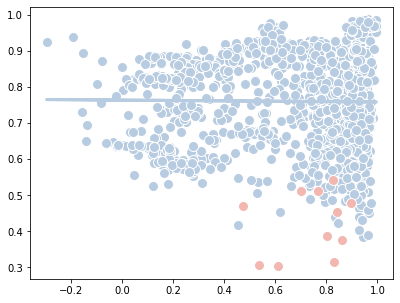

In [30]:
fig, ax = plt.subplots(1, 1)

fig.set_size_inches(w=6.50127, h=5)

ax.plot(
    generated_set_sim,
    generated_exp_var,
    "o",
    generated_set_sim,
    gen_poly1d_fn(generated_set_sim),
    color="#B8CCE1",
    linewidth=3,
    markersize=10,
    markerfacecolor="#B8CCE1",
    markeredgecolor="white",
)
ax.plot(
    gathered_set_sim,
    gathered_exp_var,
    "o",
    markersize=10,
    markerfacecolor="#F1B7B0",
    markeredgecolor="white",
)

plt.show()